# Kaggle Competition Template

1. Setting Up
* Explore the data
* Clean and Proces
* Prepare shape and format
* Train and Cross Validate models with different hyper-parameters and feature set
* Prepare a test submission

## 1. Setting Up

### Essential Libraries

In [1]:
# Essentials
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.metrics.pairwise import euclidean_distances

# Cross Validation and Data Prepataion
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import minmax_scale, MinMaxScaler

# Supervised Learning Models
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

# Unsupervised Clustering
from sklearn.cluster import KMeans

### Tweaking Pandas Options

In [2]:
pd.set_option("display.max_columns", 100)

## 2. Explore the Data

### Importing the Dataset

In [3]:
# Titanic Dataset
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

In [4]:
print("train.columns:\n", train.columns, "\n")
print("train.shape:\n", train.shape)

train.columns:
 Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object') 

train.shape:
 (891, 12)


In [5]:
print("test.columns:\n", holdout.columns, "\n")
print("test.shape:\n", holdout.shape)

test.columns:
 Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object') 

test.shape:
 (418, 11)


### Data Dictionary

| Variable 	| Definition                                 	| Key                                            	|
|----------	|--------------------------------------------	|------------------------------------------------	|
| survival 	| Survival                                   	| 0 = No, 1 = Yes                                	|
| pclass   	| Ticket class                               	| 1 = 1st, 2 = 2nd, 3 = 3rd                      	|
| sex      	| Sex                                        	|                                                	|
| Age      	| Age in years                               	|                                                	|
| sibsp    	| # of siblings / spouses aboard the Titanic 	|                                                	|
| parch    	| # of parents / children aboard the Titanic 	|                                                	|
| ticket   	| Ticket number                              	|                                                	|
| fare     	| Passenger fare                             	|                                                	|
| cabin    	| Cabin number                               	|                                                	|
| embarked 	| Port of Embarkation                        	| C = Cherbourg, Q = Queenstown, S = Southampton 	|

### Data Exploration through Visualization

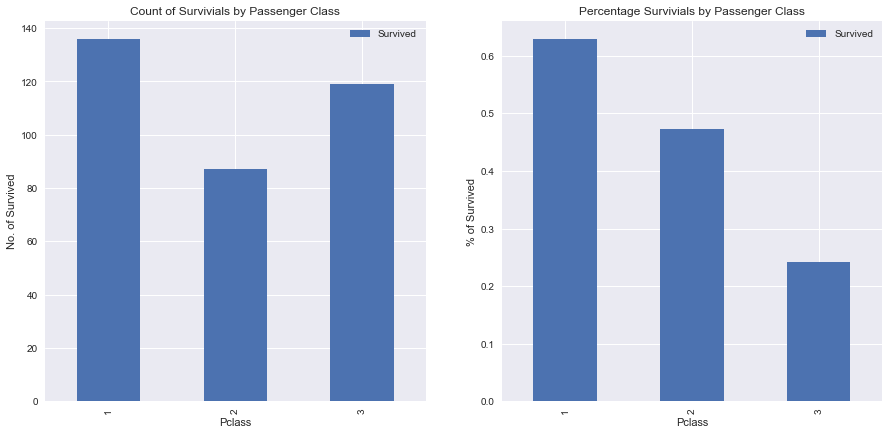

In [6]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

class_pivot = train.pivot_table(index="Pclass", values="Survived",aggfunc=sum)
class_pivot.plot.bar(ax=ax1)
ax1.set_title("Count of Survivials by Passenger Class")
ax1.set_ylabel("No. of Survived")

class_pivot = train.pivot_table(index="Pclass", values="Survived")
class_pivot.plot.bar(ax=ax2)
ax2.set_title("Percentage Survivials by Passenger Class")
ax2.set_ylabel("% of Survived")

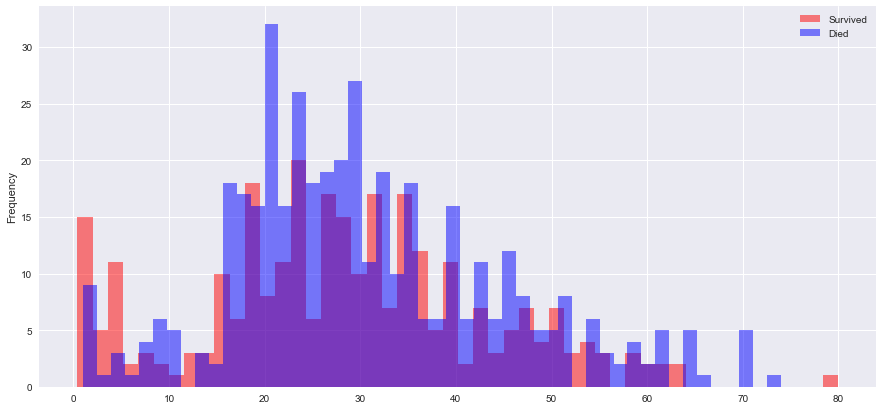

In [7]:
survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50, figsize=(15,7))
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50, figsize=(15,7))
plt.legend(['Survived','Died'])
plt.show()

## 3A. Clean and Process

### 3A.1. Identify Missing Data

In [8]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
holdout.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### 3A.2. [Fare] : Replace Numerical NA mean

In [10]:
holdout["Fare"] = holdout["Fare"].fillna(train["Fare"].mean())

### 3A.3. [Cabin] : Replace Categorical NA with Most Frequent Class

In [11]:
(train["Embarked"].value_counts()) + (holdout["Embarked"].value_counts())

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [12]:
train["Embarked"] = train["Embarked"].fillna("S")
holdout["Embarked"] = holdout["Embarked"].fillna("S")

### 3A.4. [Age & Fares] : Numeric to Binned Categories ( incl. Missing )

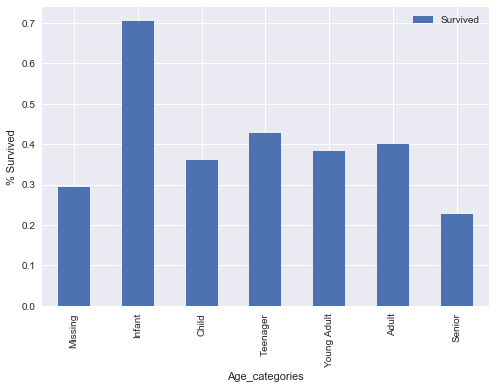

In [13]:
def process_age(df):
    df["Age"] = df["Age"].fillna(-0.5)
    
    # Splitting a continuous numeric into categories
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

# Binning both Train and Test
train = process_age(train)
holdout = process_age(holdout)

# Graph
pivot = train.pivot_table(index="Age_categories", values="Survived")
pivot.plot.bar()
plt.ylabel("% Survived")
plt.show()

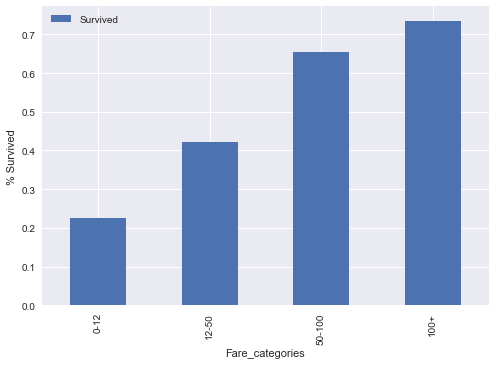

In [14]:
def process_fare(df):
    df["Fare"] = df["Fare"].fillna(-0.5)
    
    # Splitting a continuous numeric into categories
    cut_points = [0,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

# Binning both Train and Test
train = process_fare(train)
holdout = process_fare(holdout)

# Graph
pivot = train.pivot_table(index="Fare_categories", values="Survived")
pivot.plot.bar()
plt.ylabel("% Survived")
plt.show()

In [15]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_categories,Fare_categories
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Young Adult,0-12
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Adult,50-100
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Young Adult,0-12
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Young Adult,50-100
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Young Adult,0-12


In [16]:
train.isnull().sum()

PassengerId          0
Survived             0
Pclass               0
Name                 0
Sex                  0
Age                  0
SibSp                0
Parch                0
Ticket               0
Fare                 0
Cabin              687
Embarked             0
Age_categories       0
Fare_categories     15
dtype: int64

In [17]:
holdout.isnull().sum()

PassengerId          0
Pclass               0
Name                 0
Sex                  0
Age                  0
SibSp                0
Parch                0
Ticket               0
Fare                 0
Cabin              327
Embarked             0
Age_categories       0
Fare_categories      2
dtype: int64

### 3A.5. [Pclass, Sex and Age_Categories] : Multi-Class Categorical to Dummy Binary Columns

In [18]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

for col in ["Age_categories", "Fare_categories", "Pclass", "Sex","Embarked"]:
    train = create_dummies(train,col)
    holdout = create_dummies(holdout,col)

In [19]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_categories,Fare_categories,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior,Fare_categories_0-12,Fare_categories_12-50,Fare_categories_50-100,Fare_categories_100+,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Young Adult,0-12,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Adult,50-100,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Young Adult,0-12,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Young Adult,50-100,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Young Adult,0-12,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1


### 3A.6. [SibSp, Parch, Fare] Normalization with MinMaxScaler

In [20]:
train[["SibSp","Parch","Fare"]].describe()

,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000
mean,0.523008,0.381594,32.204208
std,1.102743,0.806057,49.693429
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,7.910400
50%,0.000000,0.000000,14.454200
75%,1.000000,0.000000,31.000000
max,8.000000,6.000000,512.329200


In [21]:
holdout[["SibSp","Parch","Fare"]].describe()

,SibSp,Parch,Fare
count,418.000000,418.000000,418.000000
mean,0.447368,0.392344,35.619000
std,0.896760,0.981429,55.840751
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,7.895800
50%,0.000000,0.000000,14.454200
75%,1.000000,0.000000,31.500000
max,8.000000,9.000000,512.329200


In [22]:
columns_to_norm = ["SibSp", "Parch"]

for col in columns_to_norm:
    scaler = MinMaxScaler()
    
    # Merging the Data ensures the widest range is used during normalization, ensuring there all values are between 0 and 1
    holdout_data = np.asarray(holdout[col]).reshape(-1,1)
    train_data = np.asarray(train[col]).reshape(-1,1)
    merged_data = np.concatenate([holdout_data,train_data])
    
    scaler.fit(merged_data)
    
    holdout_data_scaled = scaler.transform(holdout_data)
    train_data_scaled = scaler.transform(train_data)
    
    holdout[col+"_scaled"] = holdout_data_scaled
    train[col+"_scaled"] = train_data_scaled

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [23]:
train[["SibSp", "Parch", "SibSp_scaled", "Parch_scaled"]].describe()

,SibSp,Parch,SibSp_scaled,Parch_scaled
count,891.000000,891.000000,891.000000,891.000000
mean,0.523008,0.381594,0.065376,0.042399
std,1.102743,0.806057,0.137843,0.089562
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.125000,0.000000
max,8.000000,6.000000,1.000000,0.666667


In [24]:
holdout[["SibSp", "Parch", "SibSp_scaled", "Parch_scaled"]].describe()

,SibSp,Parch,SibSp_scaled,Parch_scaled
count,418.000000,418.000000,418.000000,418.000000
mean,0.447368,0.392344,0.055921,0.043594
std,0.896760,0.981429,0.112095,0.109048
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.125000,0.000000
max,8.000000,9.000000,1.000000,1.000000


### 3A.7. Cleaned Data Final Form

In [25]:
print("train:\n", train.shape)
train.head(5)

train:
 (891, 35)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_categories,Fare_categories,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior,Fare_categories_0-12,Fare_categories_12-50,Fare_categories_50-100,Fare_categories_100+,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,SibSp_scaled,Parch_scaled
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Young Adult,0-12,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0.125,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Adult,50-100,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0.125,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Young Adult,0-12,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0.000,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Young Adult,50-100,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0.125,0.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Young Adult,0-12,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0.000,0.0


In [26]:
print("holdout:\n", holdout.shape)
holdout.head(5)

holdout:
 (418, 34)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_categories,Fare_categories,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior,Fare_categories_0-12,Fare_categories_12-50,Fare_categories_50-100,Fare_categories_100+,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,SibSp_scaled,Parch_scaled
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Young Adult,0-12,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0.000,0.000000
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Adult,0-12,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0.125,0.000000
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Senior,0-12,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0.000,0.000000
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Young Adult,0-12,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0.000,0.000000
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Young Adult,12-50,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0.125,0.111111


# 3B. Feature Engineering

### 3B.1. [Cabin Class] String Accessor

In [27]:
train["Cabin_type"] = train["Cabin"].str[0]
train["Cabin_type"] = train["Cabin_type"].fillna("Unknown")

holdout["Cabin_type"] = holdout["Cabin"].str[0]
holdout["Cabin_type"] = holdout["Cabin_type"].fillna("Unknown")

In [28]:
train["Cabin_type"].value_counts()

Unknown    687
C           59
B           47
D           33
E           32
A           15
F           13
G            4
T            1
Name: Cabin_type, dtype: int64

In [29]:
holdout["Cabin_type"].value_counts()

Unknown    327
C           35
B           18
D           13
E            9
F            8
A            7
G            1
Name: Cabin_type, dtype: int64

### 3B.2. [Title] String Extraction

In [30]:
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

# The regex ' ([A-Za-z]+)\.' identifies any string that is one (or more) upper or lower case characters ending with a period(.)
extracted_titles = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
train["Title"] = extracted_titles.map(titles)

extracted_titles = holdout["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
holdout["Title"] = extracted_titles.map(titles)

### 3B.3. Adding Binary Dummy Columns for the New Features

In [31]:
for column in ["Title","Cabin_type"]:
    train = create_dummies(train,column)
    holdout = create_dummies(holdout,column)

In [32]:
# Check to ensure train and holdout have the same set of features
for col in train.columns:
    if col not in holdout.columns:
        print(col)

Survived
Cabin_type_T


In [33]:
# Since holdout data has no Type T Cabins at all, we must additionally add in this column
holdout["Cabin_type_T"] = 0

# 4. Prepare Shape and Format

### 4.1. Feature Selection

In [34]:
print(holdout["Cabin_type"].value_counts())

Unknown    327
C           35
B           18
D           13
E            9
F            8
A            7
G            1
Name: Cabin_type, dtype: int64


In [35]:
print(train["Cabin_type"].value_counts())

Unknown    687
C           59
B           47
D           33
E           32
A           15
F           13
G            4
T            1
Name: Cabin_type, dtype: int64


In [36]:
print(train.shape,"\n", train.columns)

(891, 52) 
 Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Fare_categories', 'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Cabin_type', 'Title', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty',
       'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T',
       'Cabin_type_Unknown'],
      dtype='object')


In [37]:
features = ['Age_categories_Missing', 'Age_categories_Infant',
            'Age_categories_Child', 'Age_categories_Teenager',
            'Age_categories_Young Adult', 'Age_categories_Adult',
            'Age_categories_Senior',  'Pclass_1', 'Pclass_2', 'Pclass_3',
            'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
            'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
            'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+',
            'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer',
            'Title_Royalty', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
            'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']

target = "Survived"
print(len(features))

36


### 4.2. Identifying & Dropping Colinear Variables ( Dummy variable trap )

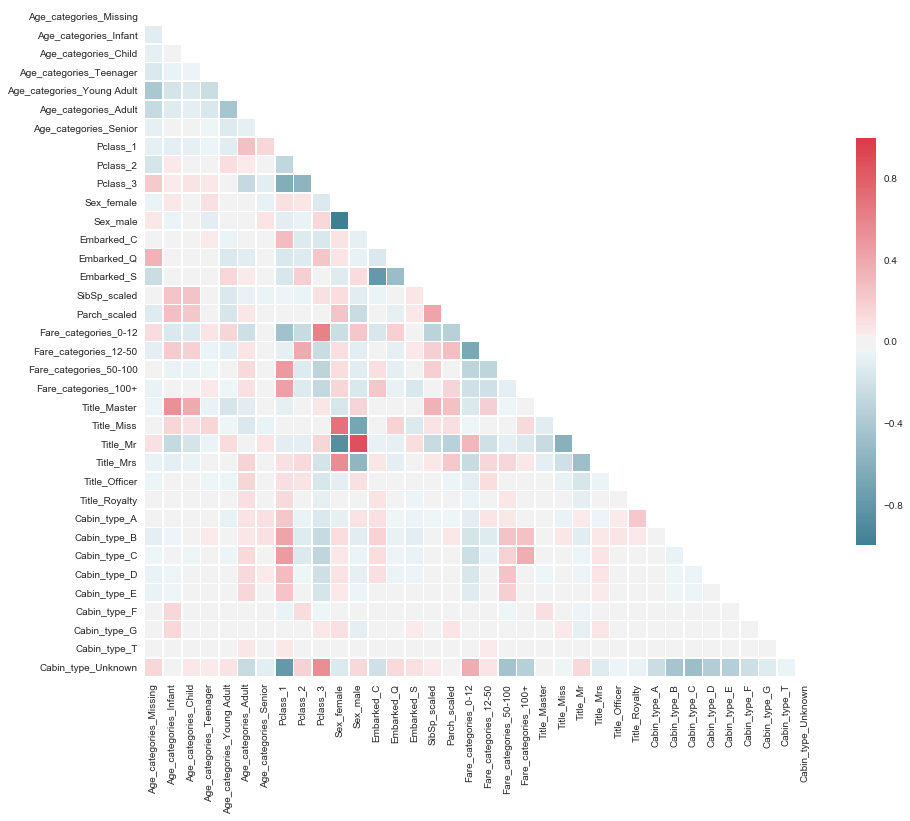

In [38]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(15, 15))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()
    
plot_correlation_heatmap(train[features])

* __Colinear Features:__
    * Pclass_2
    * Age_categories_Teenager
    * Fare_categories_12-50
    * Title_Master
    * Cabin_type_A
    
    
* __Redundant Features:__
    * Sex_female
    * Sex_male

In [39]:
features = ['Age_categories_Missing', 'Age_categories_Infant',
            'Age_categories_Child',
            'Age_categories_Young Adult', 'Age_categories_Adult',
            'Age_categories_Senior',  'Pclass_1', 'Pclass_3',
            'Embarked_C', 'Embarked_Q', 'Embarked_S',
            'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
            'Fare_categories_50-100', 'Fare_categories_100+',
            'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer',
            'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
            'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']

target = "Survived"
print(len(features))

29


### Splitting the Labelled Dataset to Train and Test

In [40]:
# Train set is split so that we can do things like cross-validation for feature selection and hyper-parameter and test against
# known answer labels.
X_train, X_test, y_train, y_test = train_test_split(train[features], train[target], test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(712, 29) (712,)
(179, 29) (179,)


# 5A. Train Model ( with Different Hyperparameters and Features )

### 5A.1. Fitting the Model and Making a Prediction

In [41]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
predictions = lr.predict(X_test)
accuracy = accuracy_score(y_test,predictions)

print("Single split Accuracy Score:", accuracy)

Single split Accuracy Score: 0.804469273743


### 5A.2. Understanding the Model

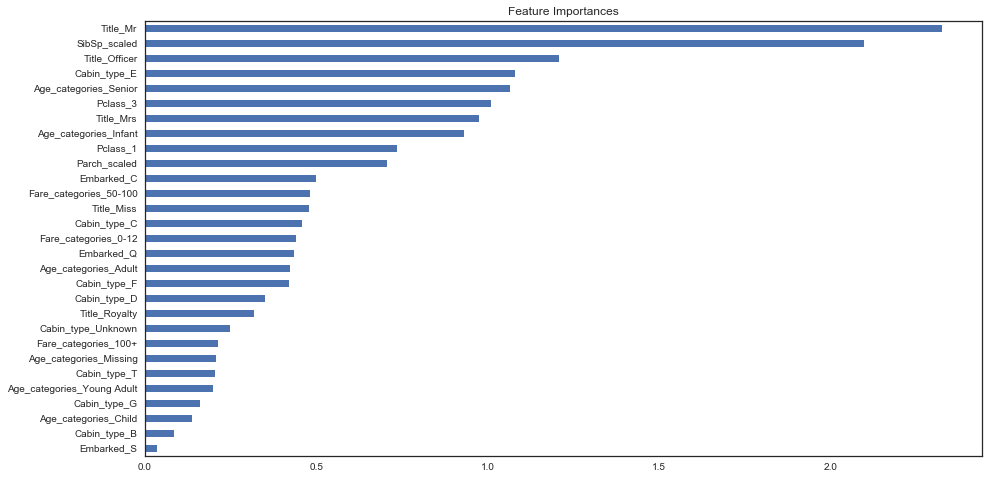

In [42]:
coefficients = lr.coef_
feature_importance = pd.Series(coefficients[0], index=train[features].columns)
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh(figsize=(15,8))
plt.title("Feature Importances")
plt.show()


### 5A.3. Cross Validation : Ensure no overfitting

In [43]:
X_all = train[features]
y_all = train[target]

lr = LogisticRegression()
scores = cross_val_score(lr, X_all, y_all, cv=10)
accuracy = scores.mean()

print("Cross Validated Accuracy Score:", accuracy)

Cross Validated Accuracy Score: 0.818260696856


# 5B. Feature Selection

### 5B.1. Recursive Feature Elimination (w/ Cross Validation)

In [44]:
X_all = train[features]
y_all = train[target]

lr = LogisticRegression()
selector = RFECV(lr, cv=10)
selector.fit(X_all,y_all)

best_features = X_all.columns[selector.support_]
print(best_features)

feature_ranking = selector.ranking_
print(feature_ranking,"\n",X_all.columns)

Index(['SibSp_scaled', 'Title_Mr', 'Title_Officer', 'Cabin_type_Unknown'], dtype='object')
[25  5 26 20 11  9 15  3 13 16 24  1  2 21  8 17  7  1  6  1 14 18 23 12 10
 19  4 22  1] 
 Index(['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled',
       'Parch_scaled', 'Fare_categories_0-12', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown'],
      dtype='object')


In [45]:
fr = pd.DataFrame(np.transpose([feature_ranking]), index=X_all.columns)
fr.sort_values(0)

,0
Cabin_type_Unknown,1
Title_Officer,1
Title_Mr,1
SibSp_scaled,1
Parch_scaled,2
Pclass_3,3
Cabin_type_G,4
Age_categories_Infant,5
Title_Mrs,6
Title_Miss,7


### 5B.2. Train with Optimized Feature Set

In [46]:
print(best_features)

Index(['SibSp_scaled', 'Title_Mr', 'Title_Officer', 'Cabin_type_Unknown'], dtype='object')


In [47]:
X_all = train[best_features]
y_all = train[target]

lr = LogisticRegression()
scores = cross_val_score(lr, X_all, y_all, cv=10)
accuracy = scores.mean()

print("Cross Validated Accuracy Score:", accuracy)

Cross Validated Accuracy Score: 0.822654919986


# 6. Prepare a test submission

__Instructions:__  
* You should submit a csv file with exactly 418 entries plus a header row. Your submission will show an error if you have extra columns (beyond PassengerId and Survived) or rows.

__The file should have exactly 2 columns:__
* PassengerId (sorted in any order)
* Survived (contains your binary predictions: 1 for survived, 0 for deceased)

| PassengerId 	| Survived 	|
|-------------	|----------	|
| 892         	| 0        	|
| 892         	| 1        	|
| 894         	| 0        	|

In [48]:
X_all = train[best_features]
y_all = train[target]

# Fit the best combination of model, features and hyperparameters to generate a prediction
lr = LogisticRegression()
lr.fit(X_all,y_all)
predict_submission = lr.predict(holdout[best_features])

In [49]:
holdout_id = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_id,
                 "Survived": predict_submission}
submission = pd.DataFrame(submission_df)
print("submission shape:", submission.shape)

submission.to_csv("submission.csv", index=False)

submission shape: (418, 2)


# 7. Improving Model Accuracy
* __Improving the features:__
    * _Feature Engineering:_ Create new features from the existing data.
    * _Feature Selection:_ Select the most relevant features to reduce noise and overfitting.  
    
    
    
* __Improving the model:__
    * _Model Selection:_ Try a variety of models to improve performance.
    * _Hyperparameter Optimization:_ Optimize the settings within each particular machine learning model.

# 8. Other Models

### 8.1. Baseline Logistic Regression

In [50]:
features = ['Age_categories_Missing', 'Age_categories_Infant',
            'Age_categories_Child',
            'Age_categories_Young Adult', 'Age_categories_Adult',
            'Age_categories_Senior',  'Pclass_1', 'Pclass_3',
            'Embarked_C', 'Embarked_Q', 'Embarked_S',
            'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
            'Fare_categories_50-100', 'Fare_categories_100+',
            'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer',
            'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
            'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']

X_all = train[features]
y_all = train['Survived']

lr = LogisticRegression()
scores = cross_val_score(lr, X_all, y_all, cv=10)
accuracy_lr = scores.mean()
print( "Logistic Regression Accuracy Score:", accuracy_lr)

Logistic Regression Accuracy Score: 0.818260696856


In [51]:
for col in train.columns:
    if col not in holdout.columns:
        print(col)

Survived


### 8.2. K-Nearest Neighbours Classifier

In [52]:
features = ['Age_categories_Missing', 'Age_categories_Infant',
            'Age_categories_Child',
            'Age_categories_Young Adult', 'Age_categories_Adult',
            'Age_categories_Senior',  'Pclass_1', 'Pclass_3',
            'Embarked_C', 'Embarked_Q', 'Embarked_S',
            'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
            'Fare_categories_50-100', 'Fare_categories_100+',
            'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer',
            'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
            'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']

X_all = train[features]
y_all = train['Survived']

knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X_all, y_all, cv=10)
accuracy_knn = scores.mean()
print( "K-Nearest Neighbours Accuracy Score:", accuracy_knn)

K-Nearest Neighbours Accuracy Score: 0.821632618318


#### Hyper Parameter Grid Search
* Takes a while...

In [53]:
hyperparameters = {
    "n_neighbors": range(1,20,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute','kd_tree','ball_tree'],
    "p": [1,2]
}

knn = KNeighborsClassifier()

# Initialize GridSearchCV object with a KNeighborsClassifier and a dict of hyperparameters to try
grid = GridSearchCV(knn, param_grid=hyperparameters, cv=10)
grid.fit(X_all,y_all)

# Best performing hyperparameters
best_params = grid.best_params_
best_score = grid.best_score_
print (best_params, best_score)

# Model with the best performing hyperparameters
best_knn = grid.best_estimator_

# Making a Prediction
predict_submission = best_knn.predict(holdout[features])

{'n_neighbors': 5, 'algorithm': 'ball_tree', 'weights': 'uniform', 'p': 2} 0.82379349046


In [54]:
# Export results
holdout_id = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_id,
                 "Survived": predict_submission}
submission = pd.DataFrame(submission_df)
print("submission shape:", submission.shape)

submission.to_csv("submission.csv", index=False)

submission shape: (418, 2)


### 8.3. Random Forest Classifier

In [55]:
features = ['Age_categories_Missing', 'Age_categories_Infant',
            'Age_categories_Child',
            'Age_categories_Young Adult', 'Age_categories_Adult',
            'Age_categories_Senior',  'Pclass_1', 'Pclass_3',
            'Embarked_C', 'Embarked_Q', 'Embarked_S',
            'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
            'Fare_categories_50-100', 'Fare_categories_100+',
            'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer',
            'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
            'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']

X_all = train[features]
y_all = train['Survived']

rf = RandomForestClassifier(random_state=0)
scores = cross_val_score(rf, X_all, y_all, cv=10)
accuracy_rf = scores.mean()
print( "Random Forest Accuracy Score:", accuracy_rf)

Random Forest Accuracy Score: 0.816000453978


#### Hyper Parameter Grid Search
* Takes a while...

In [56]:
hyperparameters = {
    "n_estimators": [5,10,50,100],
    "max_depth": [3,5,10],
    "max_features": ["sqrt","log2"],
    "min_samples_leaf": [1,5,10],
    "min_samples_split": [3,5,10]
}

rf = RandomForestClassifier(random_state=0)

# Initialize GridSearchCV object with a KNeighborsClassifier and a dict of hyperparameters to try
grid = GridSearchCV(rf, param_grid=hyperparameters, cv=10)
grid.fit(X_all,y_all)

# Best performing hyperparameters
best_params = grid.best_params_
best_score = grid.best_score_
print (best_params, best_score)

# Model with the best performing hyperparameters
best_rf = grid.best_estimator_

# Making a Prediction
predict_submission = best_rf.predict(holdout[features])

{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1} 0.832772166105


In [ ]:
# Export results
holdout_id = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_id,
                 "Survived": predict_submission}
submission = pd.DataFrame(submission_df)
print("submission shape:", submission.shape)

submission.to_csv("submission.csv", index=False)